In [8]:
import sys
sys.path.append("../../src")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from example_lorenz import generate_lorenz_data
import os
import pickle
from autoencoder import FullNetwork
import torch
from sindy_utils import sindy_simulate

data_path = os.getcwd() + '/'
save_name = 'lorenz_2024_04_07_23_29_11_426420'
params = pickle.load(open(data_path + save_name + '_params.pkl', 'rb'))
params['save_name'] = data_path + save_name

dataframe = pd.read_pickle(r'C:\Users\ianma\Desktop\Study\Python\CS4240_DeepLearning_Group41_ReproducibilityProject\Autoencoders-Reproduction\examples\experiment_results_202404080247.pkl')


Xi_plot = np.array(dataframe['coefficient_mask']*dataframe['sindy_coefficients'])[0]
sindy_coefficients = np.array(dataframe['sindy_coefficients'])[0]
coefficient_mask = np.array(dataframe['coefficient_mask'])[0]
   

In [9]:
autoencoder_network = FullNetwork(params).to(params['device'])
path = 'lorenz_2024_04_07_23_29_11_426420.pth'
state_dict = torch.load(path)
autoencoder_network.load_state_dict(state_dict)


<All keys matched successfully>

In [10]:
a1 = 1
a2 = sindy_coefficients[2,0]/sindy_coefficients[2,0]
a3 = np.sqrt(-sindy_coefficients[5,2]/sindy_coefficients[6,1]*a2**2)
b3 = -sindy_coefficients[0,2]/sindy_coefficients[3,2]

sindy_coefficients_transformed = np.zeros(sindy_coefficients.shape)
sindy_coefficients_transformed[1,0] = sindy_coefficients[1,0]
sindy_coefficients_transformed[2,0] = sindy_coefficients[2,0]*a2/a1
sindy_coefficients_transformed[1,1] = sindy_coefficients[6,1]*a1/a2*b3
sindy_coefficients_transformed[2,1] = sindy_coefficients[2,1]
sindy_coefficients_transformed[6,1] = sindy_coefficients[6,1]*a1*a3/a2
sindy_coefficients_transformed[3,2] = sindy_coefficients[3,2]
sindy_coefficients_transformed[5,2] = sindy_coefficients[5,2]*a1*a2/a3

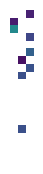

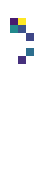

In [11]:

Xi_plot = np.where(Xi_plot == 0, np.inf, Xi_plot)
plt.figure(figsize=(1,2))
plt.imshow(Xi_plot, interpolation='none')
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.clim([-10,30])
plt.show()

Xi_transformed_plot = np.copy(sindy_coefficients_transformed)
Xi_transformed_plot[Xi_transformed_plot==0] = np.inf
plt.figure(figsize=(1,2))
plt.imshow(Xi_transformed_plot, interpolation='none')
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.clim([-10,30])
plt.show()

In [12]:
t = np.arange(0,20,.01)
z0 = np.array([[-8,7,27]])

test_data = generate_lorenz_data(z0, t, params['input_dim'], linear=False, normalization=np.array([1/40,1/40,1/40]))
test_data['x'] = torch.tensor(test_data['x'].reshape((-1,params['input_dim'])), dtype=torch.float32).to(params['device'])
test_data['dx'] = torch.tensor(test_data['dx'].reshape((-1,params['input_dim'])), dtype=torch.float32).to(params['device'])
test_data['z'] = test_data['z'].reshape((-1,params['latent_dim']))
test_data['dz'] = test_data['dz'].reshape((-1,params['latent_dim']))

In [14]:
_, _, _, test_results_z, _, _, _, _ = autoencoder_network.forward(test_data['x'], test_data['dx'])
test_results_z = test_results_z.cpu().detach().numpy()

In [ ]:
z_sim = sindy_simulate(test_results_z[0], t, params['coefficient_mask']*sindy_coefficients,
                       params['poly_order'], params['include_sine'])